<a href="https://colab.research.google.com/github/ilham-ap/poster/blob/main/cloud_detection_and_aerosol_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# download model
import subprocess

subprocess.run(['pip', 'install', 'yaspin'])
from yaspin import yaspin
with yaspin(text="Downloading model ...", spinner="moon") as spinner:
  url = 'https://drive.google.com/uc?id=19tIRxvUeendr9z8ShnTEKzmhpYLOuywM'
  subprocess.run(['pip', 'install', '--upgrade', '--no-cache-dir', 'gdown'])
  subprocess.run(['gdown', url])
  subprocess.run(['unzip', 'model.zip'])
  print('\nfinish')

⠸ Downloading model ...
finish


In [2]:
# install library requirement
with yaspin(text="install library ...", spinner="moon") as spinner:
  subprocess.run(['pip', 'install', 'netCDF4'])
  subprocess.run(['pip', 'install', 'patchify'])
  subprocess.run(['pip', 'install', 'segmentation_models'])
  subprocess.run(['pip', 'install', 'cartopy'])
  print('\nfinish')

⠹ install library ...
finish


In [3]:
# replace error file
import shutil
import os

url = 'https://drive.google.com/uc?id=1CTNJnG2NyYUfii-yCTdd3t4ncVCqGg1s'
subprocess.run(['gdown', url])
source_file_path = '/content/__init__.py'
target_file_path = '/usr/local/lib/python3.10/dist-packages/efficientnet/__init__.py'
shutil.copyfile(source_file_path, target_file_path)


'/usr/local/lib/python3.10/dist-packages/efficientnet/__init__.py'

In [ ]:
# Execute shell command to restart the Colab session
import os
os.kill(os.getpid(), 9)

#continue run next shell

# for create matfile from himawari nc
https://colab.research.google.com/drive/1B0bzencANgIpwqYxsC8N3KIKzdsQe9NK?usp=sharing

In [28]:
#make sample False if want to use your own data
from glob import glob
from google.colab import files
import subprocess

sample = True #True/False
url = 'https://drive.google.com/uc?id=1DkpPr7DPCKwnrPkvYsmIi3WMhbYRdwyv'
if sample:
  subprocess.run(['gdown', url])
  filename = glob('*.mat')
else:
  files.upload()
  filename = glob('*.mat')

In [30]:
#cloud detection
from yaspin import yaspin
import time
start_time = time.time()
with yaspin(text="Processing ...", spinner="moon") as spinner:
  import os
  import matplotlib.pyplot as plt
  import numpy as np
  import pandas as pd
  import cv2
  from patchify import patchify, unpatchify
  from numpy import save
  from natsort import natsorted
  import matplotlib.colors as mcolors
  import matplotlib.pyplot as plt
  from tensorflow.keras.utils import normalize, to_categorical
  import tensorflow as tf
  from tensorflow.keras.layers import Input
  from tensorflow.keras.models import Model
  from tensorflow.keras.layers import ReLU, concatenate,Concatenate
  import tensorflow.keras.backend as K
  import sys
  from tensorflow.keras.optimizers import Adam, SGD
  from scipy.io import savemat, loadmat
  from sklearn.model_selection import train_test_split
  tf.random.set_seed(1)
  np.random.seed(1)
  import segmentation_models as sm
  sm.set_framework('tf.keras')

  tf.device('/device:GPU:0')

  h_data = loadmat(filename[0])['h_data']
  lon = loadmat(filename[0])['lon_h']
  lat = loadmat(filename[0])['lat_h']
  times = filename[0][16:20]
  input_shape_Post = 4, 4, 6
  def model_function():
      input_Post = Input(input_shape_Post, name='Post_Input')
      #Define Unet architecture
      L = sm.Linknet(backbone_name='resnet34',classes=2, input_shape=(4, 4, 6), decoder_filters=(8,4), encoder_weights=None,activation='softmax')
      x=input_Post
      x=L(x)

      model=Model(inputs=input_Post, outputs=x)
      return model
  model = model_function()

  directory = f'linknet_model'

  os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
  for i in range(1):
    try:
      model.load_weights(f'{directory}/linknet_cloud_detection{times[:2]}.h5')
    except:
      print('\nprogram stop')
      print(f'model {directory}/linknet_cloud_detection{times[:2]}.h5 is empty')
      break

    directory = f'linknet_mat'
    if not os.path.exists(directory):
        # If the directory doesn't exist, create it
        os.mkdir(directory)


    data_5 = h_data
    post_1 = patchify(data_5, (4, 4, 6), step=1).reshape(-1,4, 4, 6)
    with tf.device('/device:GPU:0'):
      y_pred=model.predict(post_1,verbose=0)
    y_pred_argmax=np.argmax(y_pred, axis=3)
    patches = patchify(data_5[:,:,0], (4, 4), step=1)
    patches_original_shape = y_pred_argmax.reshape(patches.shape)
    reconstructed_data = unpatchify(patches_original_shape, data_5.shape[:2])
    savemat(f'{directory}/prediction_{filename[0]}', {'pred':reconstructed_data})
    elapsed_time = time.time() - start_time
    print(f'\nFinish: Elapsed time: {elapsed_time:.2f} seconds')


⠹ Processing ...
Finish: Elapsed time: 17.62 seconds


In [4]:
#load boundary
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import numpy as np
import os
from matplotlib.image import imread
from matplotlib import colors as mcolors

os.environ["GDAL_DATA"] = "/usr/local/lib/gdal"
shapefile = shpreader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
gdf = gpd.read_file(shapefile)
countries = ['Taiwan','China','Japan']
taiwan = gdf[gdf['admin'].isin(countries)]

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


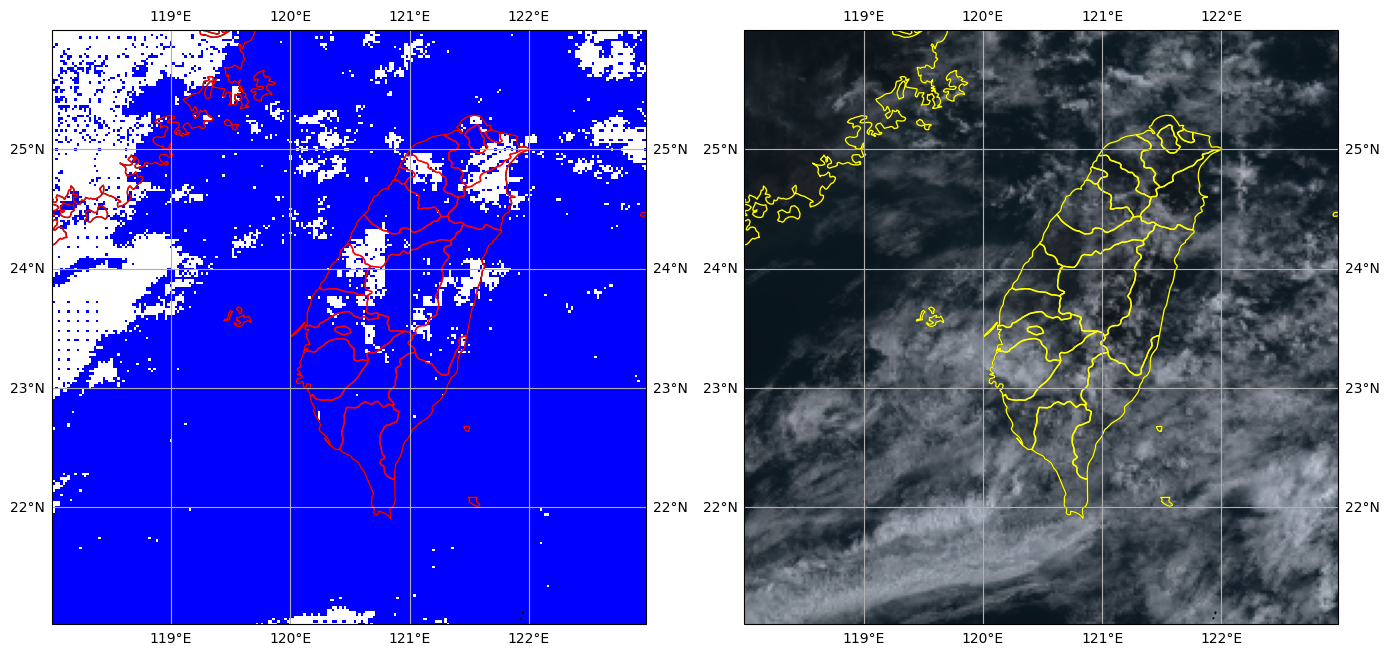

In [31]:
#plot image

colors = ['white', 'blue']
cmap = mcolors.ListedColormap(colors)

lon = loadmat(filename[0])['lon_h'][0]
lat = loadmat(filename[0])['lat_h'][0]
max_lon = max(lon)
min_lon = min(lon)
max_lat = max(lat)
min_lat = min(lat)

directory = f'linknet_mat'

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14), subplot_kw={'projection': ccrs.PlateCarree()})

extent = [min_lon, max_lon, min_lat, max_lat]

# First subplot: Taiwan with city boundaries
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.coastlines(resolution='10m',linewidth=1, edgecolor='')
for geometry in taiwan.geometry:
    ax1.add_geometries([geometry], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=1)
ax1.gridlines(draw_labels=True)
#ax1.set_title('Taiwan with City Boundaries')

lon_grid, lat_grid = np.meshgrid(lon, lat)
data = loadmat(f'{directory}/prediction_{filename[0]}')['pred']

# Plot the matrix data using pcolormesh
ax1.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1))


# Second subplot: Taiwan with RGB image overlay
ax2.set_extent(extent, crs=ccrs.PlateCarree())
ax2.coastlines(resolution='10m', edgecolor='yellow', linewidth=1)
for geometry in taiwan.geometry:
    ax2.add_geometries([geometry], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='yellow',linewidth=1)
ax2.gridlines(draw_labels=True)
#ax2.set_title('Taiwan with RGB Image Overlay')

# Load and plot the RGB image
#rgb_image = imread('path_to_your_rgb_image.png')
img_extent = extent  # Adjust these values to match the extent of your image
ax2.imshow(h_data[:,:,[2,1,0]], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())

# Display the plot
plt.tight_layout()
plt.show()


In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
import pickle
import matplotlib.pyplot as plt
from scipy.io import savemat, loadmat
directory = f'linknet_mat'
cloud_data = loadmat(f'{directory}/prediction_{filename[0]}')['pred']

x = h_data[:,:,1].reshape(-1)
y = cloud_data.reshape(-1)
y=np.float32(y)
y[y==1]=np.nan
a=np.array(np.where(np.isfinite(y)))

x_data_test = np.zeros(shape=(x[a].shape[1],3))
x_data_test[:,0] = x[a]
x_data_test[:,1] = x[a][::-1]
x_data_test[:,2] = x[a]

directory = f'rf_model'
with open(f'{directory}/random_forest_regressor.pkl', 'rb') as model_file:
    rf_regressor = pickle.load(model_file)

print("Model loaded successfully.")

# Predict on the test set
y_pred = rf_regressor.predict(x_data_test)


x2= np.zeros(shape=x.shape[0])
x2[a]=y_pred
x2[x2==0]=np.nan
x2 = x2.reshape(-1,h_data.shape[1])
directory = f'rf_mat'
if not os.path.exists(directory):
    # If the directory doesn't exist, create it
    os.mkdir(directory)
savemat(f'{directory}/prediction_rf_{filename[0]}', {'pred':x2})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.3 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded successfully.


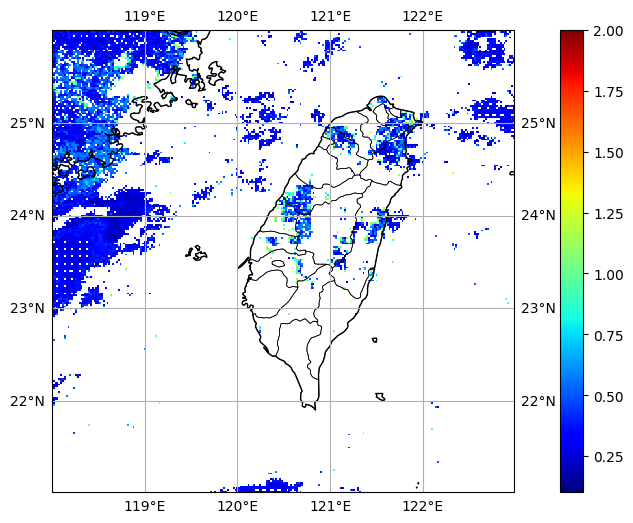

In [33]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import geopandas as gpd
import numpy as np
import os

lon = loadmat(filename[0])['lon_h'][0]
lat = loadmat(filename[0])['lat_h'][0]
max_lon = max(lon)
min_lon = min(lon)
max_lat = max(lat)
min_lat = min(lat)

plt.figure(figsize=(12, 6))

ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

ax.coastlines(resolution='10m')

for geometry in taiwan.geometry:
    ax.add_geometries([geometry], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=0.5)

ax.gridlines(draw_labels=True)


lon_grid, lat_grid = np.meshgrid(lon, lat)
directory = f'rf_mat'
data = loadmat(f'{directory}/prediction_rf_{filename[0]}')['pred']

plt.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap='jet',  vmax=2)

plt.colorbar(shrink=1)

#plt.title('Taiwan with City Boundaries and Matrix Data')

plt.show()


# Compare with himawari product

#CLOUD Product

In [66]:
# download cloud data
from ftplib import FTP
import ftplib
from natsort import natsorted
import os
from google.colab import files
from yaspin import yaspin
import sys

username = "ilhamadipanuntun_gmail.com"
password = "SP+wari8"

ftp = FTP('ftp.ptree.jaxa.jp')
ftp.login(username,password)
date = '202405/17'
time = '01'
times='0100'
folder = f'pub/himawari/L2/CLP/010/{date}/{time}'
for i in range(1):
  try:
    ftp.cwd(folder)
  except:
    print(f"folder {folder} is empty")
    break

  sorted_list = natsorted(ftp.nlst())

  filtered_times = [filename for filename in sorted_list if f'{times}' in filename]
  directory = f'cloud'
  if not os.path.exists(directory):
      # If the directory doesn't exist, create it
      os.mkdir(directory)
  with yaspin(text="Processing ...", spinner="moon") as spinner:
    for i in range(2):
      local_file = open(f'{directory}/{filtered_times[0]}', 'wb')
      ftp.retrbinary('RETR ' + filtered_times[0], local_file.write)
    print('\nfinish download')

⠇ Processing ...
finish download


In [67]:
#define latitude and longitude
lat1 = 21
lat2 = 26
lon1 = 118
lon2 = 123

In [68]:
import netCDF4
import netCDF4 as nc4
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from yaspin import yaspin
import os

with yaspin(text="Processing ...", spinner="moon") as spinner:
  directory = f'cloud'
  filename = filtered_times[0]
  f = nc4.Dataset(f'{directory}/{filename}','r', format='NETCDF4')

  lon = f.variables['longitude']
  lat = f.variables['latitude']

  lat1=np.where(lat[:].data == lat1)
  lat2=np.where(lat[:].data == lat2)
  lon1=np.where(lon[:].data == lon1)
  lon2=np.where(lon[:].data == lon2)


  # Read the variable's data into a numpy array
  band = f.variables['CLOT']
  data = band[:]
  # Reshape to a matrix with the same shape as the variable
  matrix = np.reshape(data, band.shape)
  CLOT=matrix.data[lat2[0][0]:lat1[0][0],lon1[0][0]:lon2[0][0]]
  CLOT[CLOT<=0]=0
  CLOT[CLOT>0]=1
  #print(h9_com.shape)
  CLOT_data=CLOT

lon_clot=lon[:].data[lon1[0][0]:lon2[0][0]]
lat_clot=lat[:].data[lat2[0][0]:lat1[0][0]]
directory = f'CLOT_data'
if not os.path.exists(directory):
    # If the directory doesn't exist, create it
    os.mkdir(directory)
mdic = {'CLOT_data':CLOT_data,'lon_clot':lon_clot,'lat_clot':lat_clot}
sio.savemat(f'{directory}/{filename[:-3]}.mat',mdic)
print('\nfinish')


                 
finish


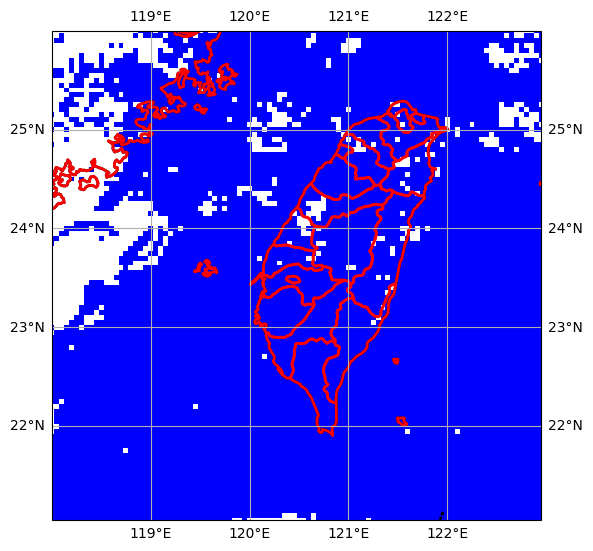

In [69]:
#plot image
directory = f'CLOT_data'
colors = ['white', 'blue']
cmap = mcolors.ListedColormap(colors)

lon = loadmat(f'{directory}/{filename[:-3]}.mat')['lon_clot'][0]
lat = loadmat(f'{directory}/{filename[:-3]}.mat')['lat_clot'][0]
max_lon = max(lon)
min_lon = min(lon)
max_lat = max(lat)
min_lat = min(lat)

fig, (ax1) = plt.subplots(1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

extent = [min_lon, max_lon, min_lat, max_lat]

# First subplot: Taiwan with city boundaries
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.coastlines(resolution='10m',linewidth=2)
for geometry in taiwan.geometry:
    ax1.add_geometries([geometry], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=2)
ax1.gridlines(draw_labels=True)
#ax1.set_title('Taiwan with City Boundaries')

lon_grid, lat_grid = np.meshgrid(lon, lat)
data = loadmat(f'{directory}/{filename[:-3]}.mat')['CLOT_data']

# Plot the matrix data using pcolormesh
ax1.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=mcolors.Normalize(vmin=0, vmax=1))

# Display the plot
plt.tight_layout()
plt.show()


#AEROSOL Product

In [56]:
# download cloud data
from ftplib import FTP
import ftplib
from natsort import natsorted
import os
from google.colab import files
from yaspin import yaspin
import sys

username = "ilhamadipanuntun_gmail.com"
password = "SP+wari8"

ftp = FTP('ftp.ptree.jaxa.jp')
ftp.login(username,password)
date = '202405/17'
time = '01'
times='0100'
folder = f'pub/himawari/L2/ARP/031/{date}/{time}'
for i in range(1):
  try:
    ftp.cwd(folder)
  except:
    print(f"folder {folder} is empty")
    break

  sorted_list = natsorted(ftp.nlst())

  filtered_times = [filename for filename in sorted_list if f'{times}' in filename]
  directory = f'AOD'
  if not os.path.exists(directory):
      # If the directory doesn't exist, create it
      os.mkdir(directory)
  with yaspin(text="Processing ...", spinner="moon") as spinner:
    for i in range(2):
      local_file = open(f'{directory}/{filtered_times[0]}', 'wb')
      ftp.retrbinary('RETR ' + filtered_times[0], local_file.write)
    print('\nfinish download')

⠏ Processing ...
finish download


In [60]:
#define latitude and longitude
lat1 = 21
lat2 = 26
lon1 = 118
lon2 = 123

In [61]:
import netCDF4
import netCDF4 as nc4
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from yaspin import yaspin
import os

with yaspin(text="Processing ...", spinner="moon") as spinner:
  directory = f'AOD'
  filename = filtered_times[0]
  f = nc4.Dataset(f'{directory}/{filename}','r', format='NETCDF4')

  lon = f.variables['longitude']
  lat = f.variables['latitude']

  lat1=np.where(lat[:].data == lat1)
  lat2=np.where(lat[:].data == lat2)
  lon1=np.where(lon[:].data == lon1)
  lon2=np.where(lon[:].data == lon2)


  # Read the variable's data into a numpy array
  band = f.variables['AOT']
  data = band[:]
  # Reshape to a matrix with the same shape as the variable
  matrix = np.reshape(data, band.shape)
  AOT=matrix.data[lat2[0][0]:lat1[0][0],lon1[0][0]:lon2[0][0]]
  AOT[AOT<=0]=np.nan
  #print(h9_com.shape)
  AOT_data=AOT

lon_aot=lon[:].data[lon1[0][0]:lon2[0][0]]
lat_aot=lat[:].data[lat2[0][0]:lat1[0][0]]
directory = f'AOT_data'
if not os.path.exists(directory):
    # If the directory doesn't exist, create it
    os.mkdir(directory)
mdic = {'AOT_data':AOT_data,'lon_aot':lon_aot,'lat_aot':lat_aot}
sio.savemat(f'{directory}/{filename[:-3]}.mat',mdic)
print('\nfinish')


                 
finish


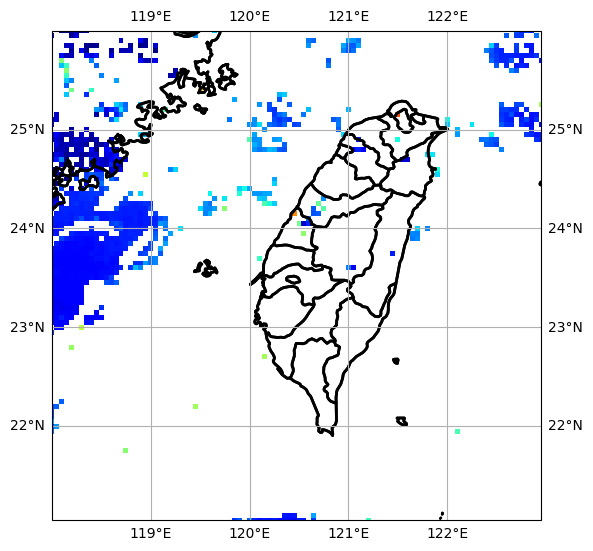

In [63]:
#plot image
directory = f'AOT_data'

lon = loadmat(f'{directory}/{filename[:-3]}.mat')['lon_aot'][0]
lat = loadmat(f'{directory}/{filename[:-3]}.mat')['lat_aot'][0]
max_lon = max(lon)
min_lon = min(lon)
max_lat = max(lat)
min_lat = min(lat)

fig, (ax1) = plt.subplots(1, figsize=(6, 6), subplot_kw={'projection': ccrs.PlateCarree()})

extent = [min_lon, max_lon, min_lat, max_lat]

# First subplot: Taiwan with city boundaries
ax1.set_extent(extent, crs=ccrs.PlateCarree())
ax1.coastlines(resolution='10m',linewidth=2)
for geometry in taiwan.geometry:
    ax1.add_geometries([geometry], crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=2)
ax1.gridlines(draw_labels=True)
#ax1.set_title('Taiwan with City Boundaries')

lon_grid, lat_grid = np.meshgrid(lon, lat)
data = loadmat(f'{directory}/{filename[:-3]}.mat')['AOT_data']

# Plot the matrix data using pcolormesh
ax1.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap='jet', vmax=2)

# Display the plot
plt.tight_layout()
plt.show()
